In [1]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [3]:
def analytical(t):
    return torch.exp(-0.4*t)*(4.59*torch.sin(1.96*t) + 5*torch.cos(1.96*t))

# We fix variables for clarity.
T = 10
zeta, omega = 0.2, 2.0
x0, v0 = 5.0, 7.0

t = torch.linspace(0, T, 128)
solution = analytical(t)

In [4]:
from pinns import Domain
from pinns.samplers import ConstantSampler, RandomSampler

constraints_sampler = ConstantSampler((
    torch.tensor([[0.]], requires_grad = True),
    torch.tensor([x0, v0])
))

domain = Domain({'t': [0, T]})
collocation_sampler = RandomSampler(domain, 256, return_dict=False)

test_points_sampler = ConstantSampler((t.view(-1, 1), solution.view(-1, 1)))

In [5]:
from pinns.derivatives import Derivative

d = Derivative(method = 'autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    zeta = 0.2, omega = 2.0
    ):
    
    def init_loss(x0, t0):
        v0 = d(x0, t0)
        return torch.mean(torch.square(torch.hstack([x0, v0]) - cstr_vals))

    def ode_loss(x, t):
        v, a = d(x, t, orders = [1, 2])
        return torch.mean(torch.square(a + 2 * zeta * omega * v + omega**2 * x))
    
    losses = (
        init_loss(cstr_pred, cstr_pts),
        ode_loss(coll_pred, coll_pts)
    )
    
    return losses

In [6]:
from pinns.analyze import InformationPropagation

ip_pts, ip_vals = test_points_sampler()
ip_pts.requires_grad_(True)

def residual(x, t):
    v, a = d(x, t, orders = [1, 2])
    return torch.square(a + 2 * zeta * omega * v + omega**2 * x)

In [101]:
from pinns import Trainer
from pinns.models import FF
from pinns.activations import Sin, Swish
from pinns.optimizers import Adam
from pinns.metrics import rel_l2

pinn = FF([1] + [32, 32] + [1], activ=nn.Tanh(), biases=False)
print(f'Model has {pinn.count_parameters()} trainable parameters.')

adam = Adam(pinn, lr = 1e-2)

ip = InformationPropagation(
    points = ip_pts, 
    values = ip_vals,
    domain = domain, 
    strategy = 'both',
    compute_every=25,
    residual = residual
)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2],
    analyzers = [ip]
)

num_iters = 4000

init_params, _ = pinn.get_parameters_vector()
trainer.train(
    num_iters=num_iters,
    optimizers=[(0, adam)],
    )

torch.save(pinn.model, './dho_4000.pt')

Model has {'total': 1120, 'trainable': 1120} trainable parameters.


  0%|          | 0/4000 [00:00<?, ?it/s]

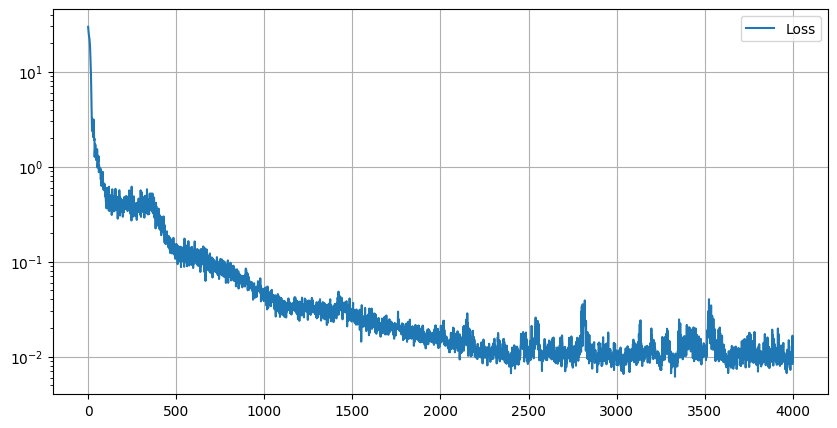

In [102]:
trainer.plot(figsize = (10, 5))

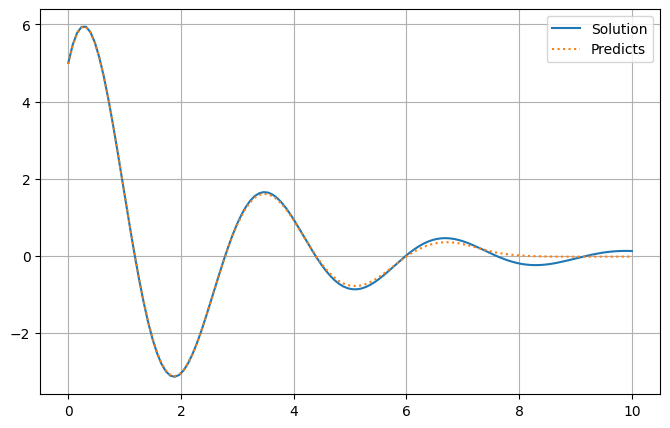

In [103]:
# pinn.model = torch.load('./very_good_model_dont_delete.pt')

fig = plt.figure(figsize=(8, 5))

preds = pinn.predict(t.reshape(-1, 1))
plt.plot(t, solution, label='Solution')
plt.plot(t, preds.detach(), label='Predicts', linestyle=':')
plt.grid()
plt.legend()

plt.show()

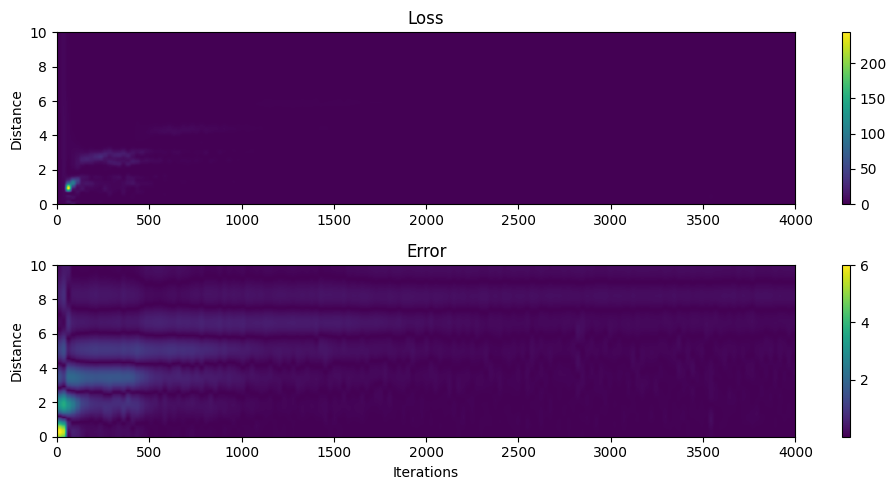

In [104]:
ip.plot(iterations=trainer.iter)

In [106]:
R = (pinn.get_parameters_vector()[0] - init_params).norm(p=2)

tensor(9.9895)

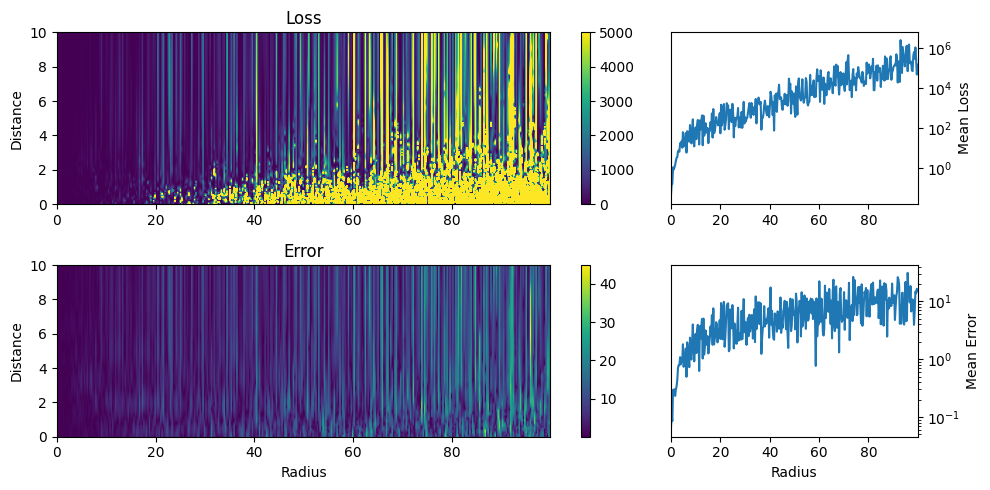

In [107]:
pinn.model = torch.load('./dho_4000.pt')
ip.pplot(pinn, R = R * 10, num_points=350, loss_vmax = 5e3)

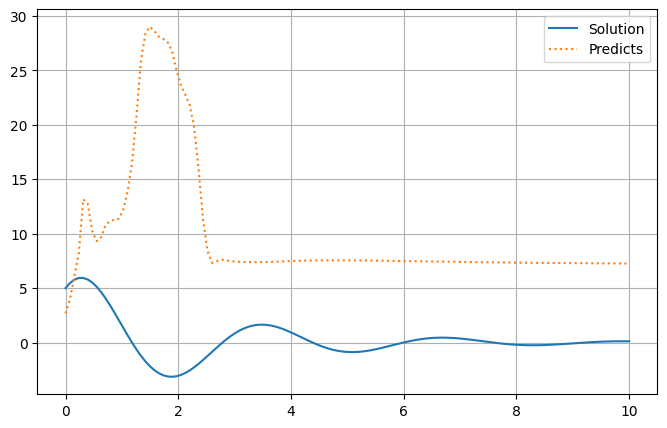

In [98]:
fig = plt.figure(figsize=(8, 5))
# pinn.model = torch.load('./dho_4000.pt')
preds = pinn.predict(t.reshape(-1, 1))
plt.plot(t, solution, label='Solution')
plt.plot(t, preds.detach(), label='Predicts', linestyle=':')
plt.grid()
plt.legend()

plt.show()